In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', 500)

df_full = pd.read_pickle('data/candlestick_15m_ETHBTC_2107291134.pkl')  # This contains all the feature columns
df_full.set_index('open_time', inplace=True)
df_full.sort_index(inplace=True)
df_full.tail()

,pair_id,close_time,dow,tod,open,high,low,close,number_of_trades,volume,quote_asset_volume,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ma14,ma30,ma90,sup14,sup30,sup90,res14,res30,res90,atr,atr_diff,atr_ma14,rsi,rsi_diff,rsi_ma14,trend_up,trend_up3,trend_up14,trend_up30,cs_ss,cs_ssr,cs_hm,cs_hmr,cs_brh,cs_buh,cs_ebu,cs_ebr,open_1,open_2,open_3,open_4,open_5,open_6,open_7,open_8,open_9,open_10,open_11,open_12,open_13,open_14,high_1,high_2,high_3,high_4,high_5,high_6,high_7,high_8,high_9,high_10,high_11,high_12,high_13,high_14,low_1,low_2,low_3,low_4,low_5,low_6,low_7,low_8,low_9,low_10,low_11,low_12,low_13,low_14,close_1,close_2,close_3,close_4,close_5,close_6,close_7,close_8,close_9,close_10,close_11,close_12,close_13,close_14,number_of_trades_1,number_of_trades_2,number_of_trades_3,number_of_trades_4,number_of_trades_5,number_of_trades_6,number_of_trades_7,number_of_trades_8,number_of_trades_9,number_of_trades_10,number_of_trades_11,number_of_trades_12,number_of_trades_13,number_of_trades_14,volume_1,volume_2,volume_3,volume_4,volume_5,volume_6,volume_7,volume_8,volume_9,volume_10,volume_11,volume_12,volume_13,volume_14,quote_asset_volume_1,quote_asset_volume_2,quote_asset_volume_3,quote_asset_volume_4,quote_asset_volume_5,quote_asset_volume_6,quote_asset_volume_7,quote_asset_volume_8,quote_asset_volume_9,quote_asset_volume_10,quote_asset_volume_11,quote_asset_volume_12,quote_asset_volume_13,quote_asset_volume_14,taker_buy_base_asset_volume_1,taker_buy_base_asset_volume_2,taker_buy_base_asset_volume_3,taker_buy_base_asset_volume_4,taker_buy_base_asset_volume_5,taker_buy_base_asset_volume_6,taker_buy_base_asset_volume_7,taker_buy_base_asset_volume_8,taker_buy_base_asset_volume_9,taker_buy_base_asset_volume_10,taker_buy_base_asset_volume_11,taker_buy_base_asset_volume_12,taker_buy_base_asset_volume_13,taker_buy_base_asset_volume_14,taker_buy_quote_asset_volume_1,taker_buy_quote_asset_volume_2,taker_buy_quote_asset_volume_3,taker_buy_quote_asset_volume_4,taker_buy_quote_asset_volume_5,taker_buy_quote_asset_volume_6,taker_buy_quote_asset_volume_7,taker_buy_quote_asset_volume_8,taker_buy_quote_asset_volume_9,taker_buy_quote_asset_volume_10,taker_buy_quote_asset_volume_11,taker_buy_quote_asset_volume_12,taker_buy_quote_asset_volume_13,taker_buy_quote_asset_volume_14,ma14_1,ma14_2,ma14_3,ma14_4,ma14_5,ma14_6,ma14_7,ma14_8,ma14_9,ma14_10,ma14_11,ma14_12,ma14_13,ma14_14,ma30_1,ma30_2,ma30_3,ma30_4,ma30_5,ma30_6,ma30_7,ma30_8,ma30_9,ma30_10,ma30_11,ma30_12,ma30_13,ma30_14,ma90_1,ma90_2,ma90_3,ma90_4,ma90_5,ma90_6,ma90_7,ma90_8,ma90_9,ma90_10,ma90_11,ma90_12,ma90_13,ma90_14,sup14_1,sup14_2,sup14_3,sup14_4,sup14_5,sup14_6,sup14_7,sup14_8,sup14_9,sup14_10,sup14_11,sup14_12,sup14_13,sup14_14,sup30_1,sup30_2,sup30_3,sup30_4,sup30_5,sup30_6,sup30_7,sup30_8,sup30_9,sup30_10,sup30_11,sup30_12,sup30_13,sup30_14,sup90_1,sup90_2,sup90_3,sup90_4,sup90_5,sup90_6,sup90_7,sup90_8,sup90_9,sup90_10,sup90_11,sup90_12,sup90_13,sup90_14,...,atr_3,atr_4,atr_5,atr_6,atr_7,atr_8,atr_9,atr_10,atr_11,atr_12,atr_13,atr_14,atr_diff_1,atr_diff_2,atr_diff_3,atr_diff_4,atr_diff_5,atr_diff_6,atr_diff_7,atr_diff_8,atr_diff_9,atr_diff_10,atr_diff_11,atr_diff_12,atr_diff_13,atr_diff_14,atr_ma14_1,atr_ma14_2,atr_ma14_3,atr_ma14_4,atr_ma14_5,atr_ma14_6,atr_ma14_7,atr_ma14_8,atr_ma14_9,atr_ma14_10,atr_ma14_11,atr_ma14_12,atr_ma14_13,atr_ma14_14,rsi_1,rsi_2,rsi_3,rsi_4,rsi_5,rsi_6,rsi_7,rsi_8,rsi_9,rsi_10,rsi_11,rsi_12,rsi_13,rsi_14,rsi_diff_1,rsi_diff_2,rsi_diff_3,rsi_diff_4,rsi_diff_5,rsi_diff_6,rsi_diff_7,rsi_diff_8,rsi_diff_9,rsi_diff_10,rsi_diff_11,rsi_diff_12,rsi_diff_13,rsi_diff_14,rsi_ma14_1,rsi_ma14_2,rsi_ma14_3,rsi_ma14_4,rsi_ma14_5,rsi_ma14_6,rsi_ma14_7,rsi_ma14_8,rsi_ma14_9,rsi_ma14_10,rsi_ma14_11,rsi_ma14_12,rsi_ma14_13,rsi_ma14_14,trend_up_1,trend_up_2,trend_up_3,trend_up_4,trend_up_5,trend_up_6,trend_up_7,trend_up_8,trend_up_9,trend_up_10,trend_up_11,trend_up_12,trend_up_13,trend_up_14,trend_up3_1,trend_up3_2,trend_up3_3,trend_up3_4,trend_up3_5,

In [2]:
df_col_full = list(df_full.columns)
df_col_diff = df_col_full.copy()
for c in ['open','high','low','close']:
    df_col_diff.remove(c)
df = df_full[['open','high','low','close']].copy()

In [3]:
def add_lookback_trades(df, levels=1, cols=['open','high','low','close']):
    '''
    Adds [cols] columns for previous records to each row. New columns are
    suffixed with the record backstep. For example: open_1 means the open
    price 1 record back.
    '''
    new_df = df.copy()
    for l in range(1,levels+1):
        new_cols={c:f'{c}_{l}' for c in cols}
        new_df = new_df.merge(df[cols].shift(l).bfill().rename(columns=new_cols),
                              how='left', left_index=True, right_index=True)
    return new_df

def add_lookforward_trades(df, levels=1, cols=['open','high','low','close']):
    '''
    Adds [cols] columns for future records to each row. New columns are
    suffixed with the record forwardstep. For example: open_1 means the open
    price 1 record forward.
    '''
    new_df = df.copy()
    for l in range(1,levels+1):
        new_cols={c:f'{c}_{l}' for c in cols}
        new_df = new_df.merge(df[cols].shift(-l).ffill().rename(columns=new_cols),
                              how='left', left_index=True, right_index=True)
    return new_df

def calculate_atr(df, period=14):
    '''
    Calculate the Average True Range (ATR)
    '''
    df2=df[['high','low','close']].copy()
    df2=add_lookback_trades(df2,1,['high','low','close'])
    df2['tr_calc'] = np.max([df2.high, df2.close_1], axis=0) - np.min([df2.low, df2.close_1], axis=0)
    return df2.tr_calc.rolling(period, min_periods=1).mean()

In [4]:
def keep_only_first(y, keep=2):
    '''
    Keep only the first X "True" values in a sequence.
    For example: T,F,F,T,T,T,F,T,F  and keep=2
                 T,F,F,T,T,F,F,T,F
                           *
    '''
    boolean_out=False
    if y.dtype == bool:
        boolean_out=True
    new_y = y.copy().astype(int)
    
    prev_ones=0
    for r in new_y.iteritems():
        if r[1]==0 and prev_ones>0:
            prev_ones=0
        elif r[1]==1 and prev_ones<keep:
            prev_ones+=1
        elif r[1]==1:
            new_y.at[r[0]]=0
    
    if boolean_out:
        new_y=new_y.astype(bool)
    
    return new_y

def to_buy(x, reverse=False):
    '''
    If first candle to pass high/low column is the target,
    mark te row "True" for buying
    '''
    high_col = x.pass_high_col
    high_col_num = int(high_col[high_col.find('_')+1:])
    low_col = x.pass_low_col
    low_col_num = int(low_col[low_col.find('_')+1:])
    
    if not reverse:
        if high_col_num < low_col_num and high_col_num > 1:
            return True
        elif low_col_num == 1:
            if not x[low_col] and x[high_col]:
                return True
            else:
                return False
        else:
            return False
    else:
        if low_col_num < high_col_num and low_col_num > 1:
            return True
        elif high_col_num == 1:
            if not x[high_col] and x[low_col]:
                return True
            else:
                return False
        else:
            return False
            
def build_Xy(df, df_full, window=14, threshold_ratio=(0.04,0.02), use_atr=True,
             atr_ratio=(2,1), reverse=False, debug=False):
    '''
    Build the X,y datasets
    
    Parameters
    ----------
    window : int
        number of records to look into the future to determine if this was a buy
    
    threshold_ratio : tuple(float,float)
        The high/low percentage to calculate target/stop-loss. Ignore if use_atr is True.
    
    use_atr : boolean
        Use the ATR to calculate stop-loss
    
    atr_ratio : tuple(int,int)
        The high/low multiplier for ATR to calculate target/stop-loss. Only used when
        use_atr is True.
    
    reverse : boolean
        buying the other currency thus reverse logic
    
    debug : boolean
        show messages
    
    '''
    if use_atr==False and (not type(threshold_ratio) == tuple or len(threshold_ratio) != 2):
        raise Exception("Parameter 'threshold_ratio' must be a tuple of size 2")
    if use_atr==True and (not type(atr_ratio) == tuple or len(atr_ratio) != 2):
        raise Exception("Parameter 'atr_ratio' must be a tuple of size 2")
    
    df2 = df.copy()
    
    print(' Build: Adding look-forward trades') if debug else None
    df2 = add_lookforward_trades(df2, levels=window, cols=['high','low'])
    
    high_cols = [f'high_{i}' for i in range(1,window+1)]
    low_cols = [f'low_{i}' for i in range(1,window+1)]
    
    # Calculate target and stop-loss
    print(' Build: Calculating target and stop-loss') if debug else None
    if not reverse:
        if use_atr:
            df2['atr'] = calculate_atr(df2)
            df2['stop_loss'] = df2.low-(df2.atr*atr_ratio[1])
            df2['target'] = df2.close+(df2.atr*atr_ratio[0])
        else:
            df2['stop_loss'] = df2.close-df2.close*threshold_ratio[1]
            df2['target'] = df2.close+df2.close*threshold_ratio[0]
    else:  # reverse
        if use_atr:
            df2['atr'] = calculate_atr(df2)
            df2['stop_loss'] = df2.high+(df2.atr*atr_ratio[1])
            df2['target'] = df2.close-(df2.atr*atr_ratio[0])
        else:
            df2['stop_loss'] = df2.close+df2.close*threshold_ratio[1]
            df2['target'] = df2.close-df2.close*threshold_ratio[0]
            
    # Determine if price crossed the target and/or stop-loss
    print(' Build: Determining break points') if debug else None
    for h,l in zip(high_cols, low_cols):
        if not reverse:
            df2[h] = df2[h]>=df2.target
            df2[l] = df2[l]<=df2.stop_loss
        else:  # reverse
            df2[l] = df2[l]<=df2.target
            df2[h] = df2[h]>=df2.stop_loss
    
    # Identify the first column that pass the target/stop-loss
    # WARNING: this is assuming idxmax() will continue to
    # return the FIRST column with a True value.
    print(' Build: Identifying target/stop-loss columns') if debug else None
    df2['pass_high_col'] = df2[high_cols].idxmax(axis=1)
    df2['pass_low_col'] = df2[low_cols].idxmax(axis=1)
    
    print(' Build: Determining buy records') if debug else None
    df2['buy'] = df2.apply(to_buy,reverse=reverse,axis=1)
    
    # Build X/y
    X = df.merge(df_full, how='left', left_index=True, right_index=True)
    y = df2[['buy']].astype(int)
    
    print(' Build: Dropping Unnecessary columns') if debug else None
    columns_to_drop = ['pair_id','close_time']
    X.drop(columns=columns_to_drop, inplace=True)
    
    print (' Build: Dropping NaN rows') if debug else None
    not_nan_rows = X.notnull().all(axis=1)
    X = X[not_nan_rows]
    y = y[not_nan_rows]
    
    print(' Build: Converting booleans to ints') if debug else None
    for col in X.columns:
        if X[col].dtype.kind in ['b','O']:
            X[col] = X[col].astype(int)
    
    #print(' Build: Trimming buy sequence to 2')
    #y.buy = keep_only_first(y.buy, keep=2)
    
    return X, y, df2

window=30

# Based on ATR Ratio

  0%|          | 0/9 [00:00<?, ?it/s]

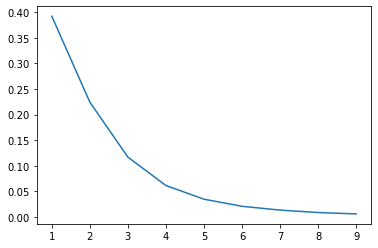

In [6]:
# y-axis is the ratio of buys/not-buys for all data in the 
# x-axis is the ratio denominator

rng=range(1,10)

results2=[]
for i in tqdm(rng):
    _, y, _ = build_Xy(df, df_full[df_col_diff], window=window, use_atr=True, atr_ratio=(i*2,i), reverse=True)
    results2.append(y.sum() / len(y))
    
plt.plot(rng, results2)

  0%|          | 0/9 [00:00<?, ?it/s]

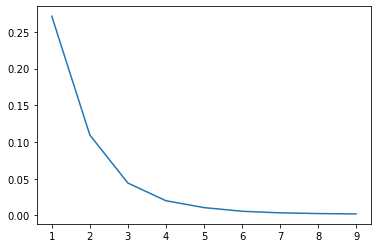

In [7]:
results3=[]
rng = range(1,10)
for i in tqdm(rng):
    _, y, _ = build_Xy(df, df_full[df_col_diff], window=window, use_atr=True, atr_ratio=(i*3,i), reverse=True)
    results3.append(y.sum() / len(y))
plt.plot(rng, results3)

  0%|          | 0/9 [00:00<?, ?it/s]

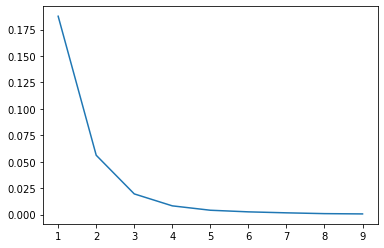

In [8]:
results4=[]
rng = range(1,10)
for i in tqdm(rng):
    _, y, _ = build_Xy(df, df_full[df_col_diff], window=window, use_atr=True, atr_ratio=(i*4,i), reverse=True)
    results4.append(y.sum() / len(y))
plt.plot(rng, results4)

  0%|          | 0/9 [00:00<?, ?it/s]

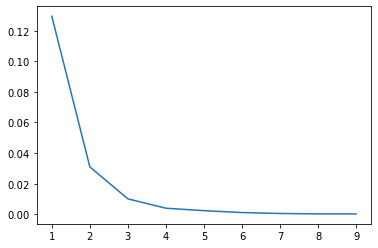

In [9]:
results5=[]
rng = range(1,10)
for i in tqdm(rng):
    _, y, _ = build_Xy(df, df_full[df_col_diff], window=window, use_atr=True, atr_ratio=(i*5,i), reverse=True)
    results5.append(y.sum() / len(y))
plt.plot(rng, results5)

  0%|          | 0/6 [00:00<?, ?it/s]

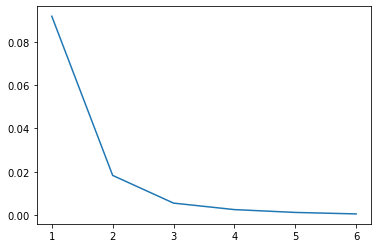

In [10]:
results6=[]
rng = range(1,7)
for i in tqdm(rng):
    _, y, _ = build_Xy(df, df_full[df_col_diff], window=window, use_atr=True, atr_ratio=(i*6,i), reverse=True)
    results6.append(y.sum() / len(y))
plt.plot(rng, results6)

In [11]:
results2

[buy    0.391821
 dtype: float64,
 buy    0.224121
 dtype: float64,
 buy    0.11682
 dtype: float64,
 buy    0.061329
 dtype: float64,
 buy    0.034659
 dtype: float64,
 buy    0.02079
 dtype: float64,
 buy    0.013359
 dtype: float64,
 buy    0.008621
 dtype: float64,
 buy    0.005915
 dtype: float64]

In [12]:
results3

[buy    0.271353
 dtype: float64,
 buy    0.109581
 dtype: float64,
 buy    0.044151
 dtype: float64,
 buy    0.020067
 dtype: float64,
 buy    0.010724
 dtype: float64,
 buy    0.005731
 dtype: float64,
 buy    0.003577
 dtype: float64,
 buy    0.0026
 dtype: float64,
 buy    0.002111
 dtype: float64]

# Based on Percentage Threshold

In [5]:
[0.00125*2**i for i in range(7)]

[0.00125, 0.0025, 0.005, 0.01, 0.02, 0.04, 0.08]

  0%|          | 0/7 [00:00<?, ?it/s]

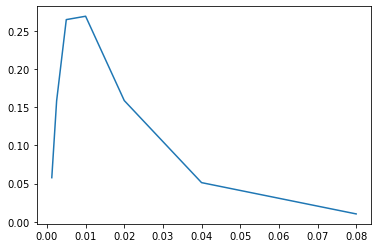

In [10]:
results_p1=[]
rng = [0.00125*2**i for i in range(7)]
for i in tqdm(rng):
    _, y, _ = build_Xy(df, df_full[df_col_diff], window=window, use_atr=False, threshold_ratio=(i,i/2), reverse=True)
    results_p1.append(y.sum() / len(y))
plt.plot(rng, results_p1)

  0%|          | 0/7 [00:00<?, ?it/s]

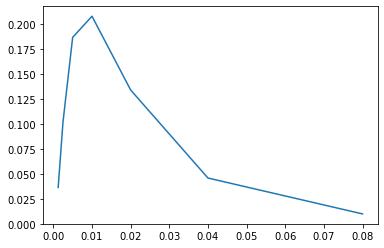

In [11]:
results_p1=[]
rng = [0.00125*2**i for i in range(7)]
for i in tqdm(rng):
    _, y, _ = build_Xy(df, df_full[df_col_diff], window=window, use_atr=False, threshold_ratio=(i,i/3), reverse=True)
    results_p1.append(y.sum() / len(y))
plt.plot(rng, results_p1)

  0%|          | 0/7 [00:00<?, ?it/s]

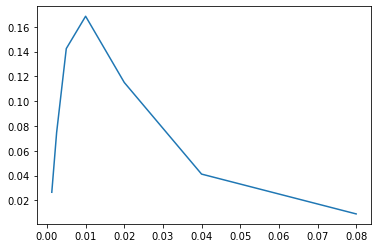

In [12]:
results_p1=[]
rng = [0.00125*2**i for i in range(7)]
for i in tqdm(rng):
    _, y, _ = build_Xy(df, df_full[df_col_diff], window=window, use_atr=False, threshold_ratio=(i,i/4), reverse=True)
    results_p1.append(y.sum() / len(y))
plt.plot(rng, results_p1)

  0%|          | 0/7 [00:00<?, ?it/s]

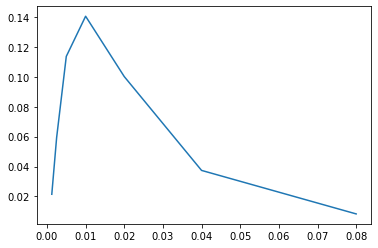

In [13]:
results_p1=[]
rng = [0.00125*2**i for i in range(7)]
for i in tqdm(rng):
    _, y, _ = build_Xy(df, df_full[df_col_diff], window=window, use_atr=False, threshold_ratio=(i,i/5), reverse=True)
    results_p1.append(y.sum() / len(y))
plt.plot(rng, results_p1)